## Compare Network Architectures: HardDeepFakes

In [1]:
from fastai.core import *
from fastai.vision import *

In [2]:
path_easy = Path('../data/EasyDeepFakes')
src_easy = ImageList.from_folder(path_easy).split_by_folder(train='train', valid='val')

In [3]:
path_hard = Path('../data/HardDeepFakes')
src_hard = ImageList.from_folder(path_hard).split_by_folder(train='train', valid='val')

In [4]:
def get_data(src, bs,size):
    data = (src.label_from_re('([A-Z]+).png$')
           .transform(get_transforms(max_warp=0, max_zoom=0), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    return data

In [5]:
bs, sz = 32, 256

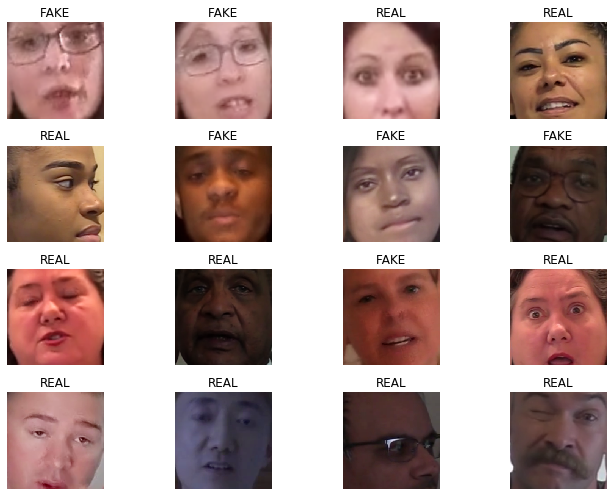

In [6]:
data_easy = get_data(src_easy, bs, sz)
data_easy.show_batch(rows=4, figsize=(10,7))

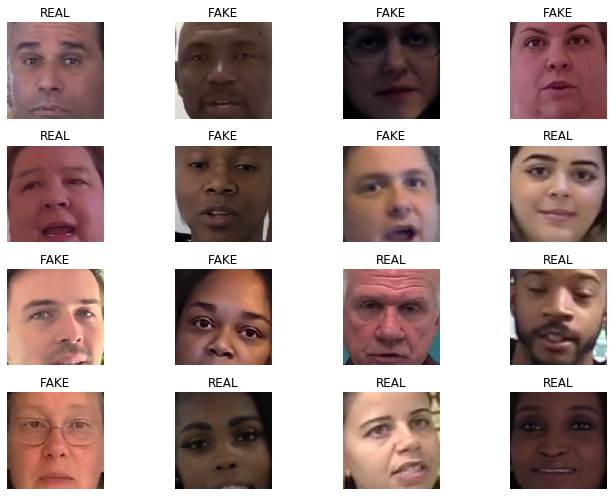

In [7]:
data_hard = get_data(src_hard, bs, sz)
data_hard.show_batch(rows=4, figsize=(10,7))

# ResNet

In [8]:
def run_resnet(model):
    learner = cnn_learner(data_easy, model, metrics=[accuracy])
    learner.lr_find()
    learner.recorder.plot()
    
    # Train only the head of the network
    learner.fit_one_cycle(5, 1e-3)
    # Unfreeze other layers and train the entire network
    learner.unfreeze()
    learner.fit_one_cycle(20, max_lr=slice(1e-5, 1e-3))
    
    learner.data = data_hard
    
    # Train only the head of the network
    learner.fit_one_cycle(5, 1e-3)
    # Unfreeze other layers and train the entire network
    learner.unfreeze()
    learner.fit_one_cycle(20, max_lr=slice(1e-5, 1e-3))
    
    
    
    # Post-Training Review
    learner.recorder.plot_losses()
    
    interp = ClassificationInterpretation.from_learner(learner)
    interp.plot_confusion_matrix()
    
    interp.plot_top_losses(9, figsize=(10,10))

### ResNet18

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,1.028235,0.604320,0.718987,00:05
1,0.833864,0.512636,0.764557,00:05
2,0.640281,0.464117,0.807595,00:05
3,0.498723,0.394041,0.827848,00:05
4,0.453851,0.389649,0.830380,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.386838,0.378178,0.827848,00:06
1,0.351023,0.358429,0.832911,00:05
2,0.300534,0.373564,0.845570,00:05
3,0.236243,0.373003,0.845570,00:05
4,0.190128,0.587751,0.840506,00:05
5,0.158166,0.524171,0.843038,00:05
6,0.138111,0.478207,0.878481,00:06
7,0.112390,0.623520,0.832911,00:05
8,0.078243,0.612040,0.865823,00:05
9,0.068542,0.589197,0.878481,00:05


epoch,train_loss,valid_loss,accuracy,time
0,1.214838,2.447572,0.612500,00:05
1,0.711788,1.402637,0.610000,00:06
2,0.461204,0.741363,0.675000,00:05
3,0.287655,0.735686,0.697500,00:06
4,0.180300,0.600456,0.732500,00:06


epoch,train_loss,valid_loss,accuracy,time
0,0.105192,0.614306,0.730000,00:05
1,0.095362,0.653869,0.750000,00:06
2,0.086021,0.727164,0.750000,00:05
3,0.080366,0.870131,0.740000,00:05
4,0.084557,1.056500,0.692500,00:06
5,0.062399,1.071752,0.735000,00:06
6,0.063149,1.181950,0.690000,00:05
7,0.076842,1.076194,0.695000,00:06
8,0.062529,1.015264,0.725000,00:05
9,0.047730,1.096060,0.745000,00:06


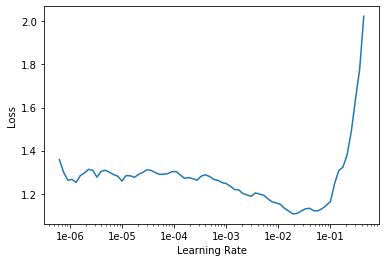

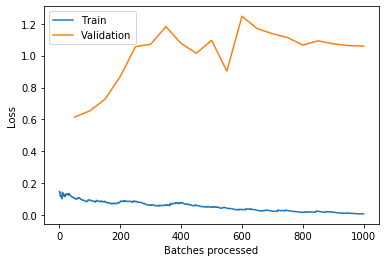

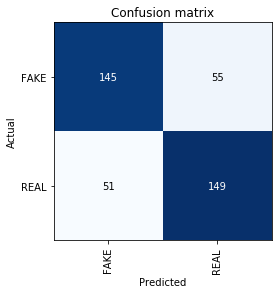

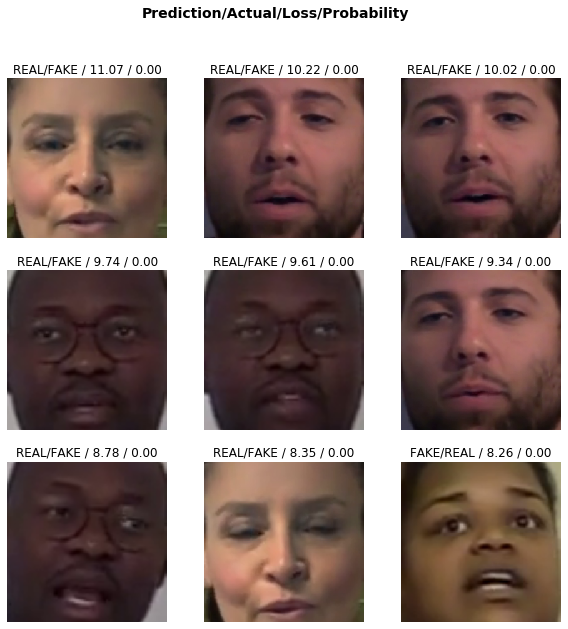

In [14]:
from fastai.vision.models import resnet18
run_resnet(resnet18)

`resnet18` has a final accuracy of **73.5%** and a peak accuracy of **78%**

### ResNet34

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/nathan/.cache/torch/checkpoints/resnet34-333f7ec4.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,1.057273,0.769512,0.648101,00:06
1,0.849098,0.740518,0.701266,00:06
2,0.639159,0.688694,0.721519,00:06
3,0.487241,0.649866,0.756962,00:06
4,0.410281,0.629936,0.741772,00:06


epoch,train_loss,valid_loss,accuracy,time
0,0.385797,0.579988,0.767089,00:07
1,0.311951,0.588246,0.782278,00:07
2,0.263065,0.530990,0.820253,00:07
3,0.219795,0.611284,0.802532,00:07
4,0.159832,0.583676,0.822785,00:07
5,0.138716,0.679530,0.812658,00:07
6,0.141715,0.923755,0.805063,00:07
7,0.095389,0.714555,0.832911,00:08
8,0.085599,0.513071,0.870886,00:07
9,0.055126,0.642324,0.825316,00:07


epoch,train_loss,valid_loss,accuracy,time
0,1.041459,9.223797,0.530000,00:07
1,0.684105,0.761558,0.630000,00:07
2,0.481067,0.621675,0.682500,00:08
3,0.318815,0.737948,0.702500,00:07
4,0.199373,0.718804,0.702500,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.108127,0.825557,0.702500,00:07
1,0.101851,0.966737,0.712500,00:07
2,0.093863,1.213181,0.695000,00:07
3,0.085409,1.411334,0.710000,00:07
4,0.086161,1.408332,0.700000,00:07
5,0.091730,1.131045,0.710000,00:07
6,0.073592,1.055050,0.770000,00:07
7,0.068975,1.327940,0.740000,00:07
8,0.074301,1.350592,0.702500,00:07
9,0.064602,0.961743,0.742500,00:07


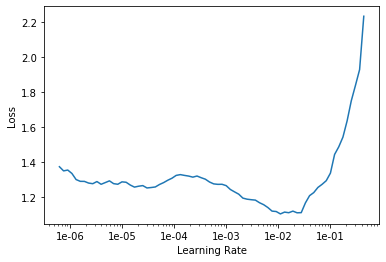

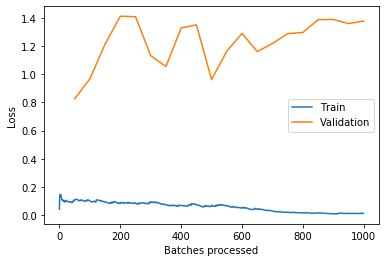

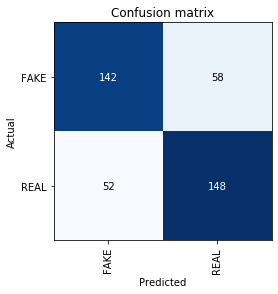

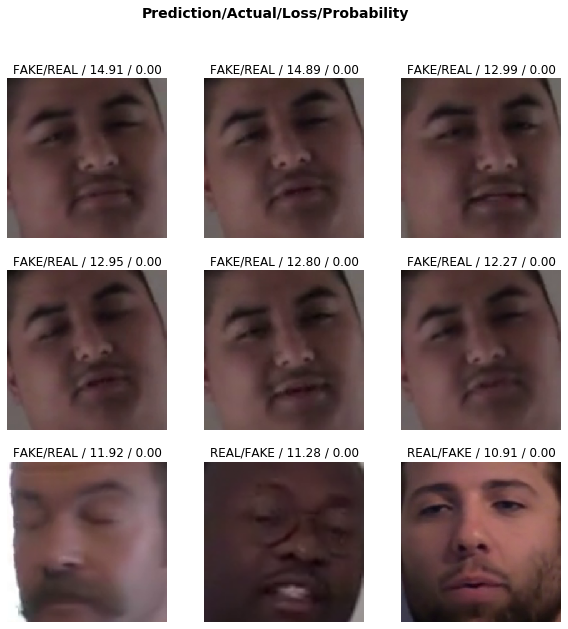

In [15]:
from fastai.vision.models import resnet34
run_resnet(resnet34)

`resnet34` has a final accuracy of **72.5%** and a peak accuracy of **77.0%**

### ResNet50

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,0.930474,0.839552,0.734177,00:09
1,0.723195,0.652504,0.767089,00:09
2,0.484755,0.665029,0.802532,00:09
3,0.334653,0.509168,0.789873,00:09
4,0.257127,0.549513,0.794937,00:09


epoch,train_loss,valid_loss,accuracy,time
0,0.248790,0.520161,0.805063,00:11
1,0.190168,0.622981,0.812658,00:11
2,0.139455,0.617388,0.807595,00:11
3,0.174523,0.421290,0.853165,00:12
4,0.186373,1.112127,0.756962,00:11
5,0.136973,0.546549,0.827848,00:11
6,0.098831,0.675170,0.840506,00:11
7,0.088951,0.436251,0.855696,00:11
8,0.072133,0.706525,0.860759,00:11
9,0.059954,0.493818,0.860759,00:12


epoch,train_loss,valid_loss,accuracy,time
0,1.090826,0.913823,0.612500,00:12
1,0.718322,0.731271,0.580000,00:11
2,0.519635,0.885572,0.577500,00:11
3,0.363280,0.652228,0.682500,00:11
4,0.239594,0.758436,0.655000,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.130045,0.844963,0.657500,00:11
1,0.136939,0.973316,0.662500,00:11
2,0.130856,0.868420,0.677500,00:12
3,0.101859,1.129238,0.722500,00:11
4,0.109911,1.164437,0.660000,00:11
5,0.100512,1.266392,0.702500,00:11
6,0.102611,1.196703,0.675000,00:11
7,0.089804,1.519777,0.682500,00:11
8,0.054010,1.618324,0.640000,00:12
9,0.055379,1.435595,0.685000,00:12


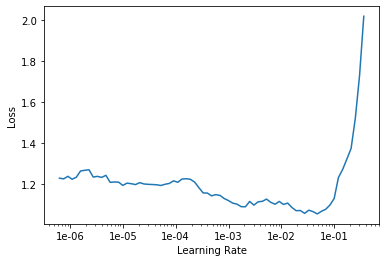

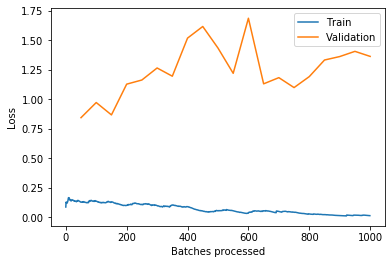

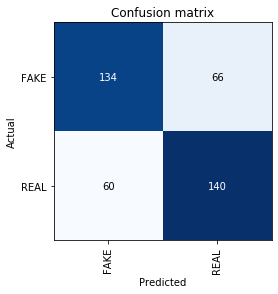

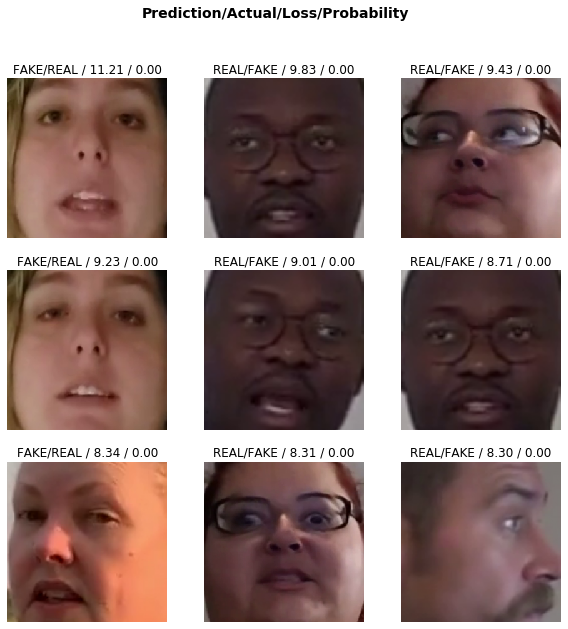

In [13]:
from fastai.vision.models import resnet50
run_resnet(resnet50)

`resnet50` has a final accuracy of **68.5%** and a peak accuracy of **72.25%**.

# EfficientNet

In [8]:
# !pip install efficientnet-pytorch
from efficientnet_pytorch import EfficientNet

In [9]:
def run_efficientnet(model):
    learner = Learner(data_easy, model, metrics=[accuracy])

    learner.lr_find()
    learner.recorder.plot()
    
    # Train only the head of the network
    learner.fit_one_cycle(5, 1e-3)
    # Unfreeze other layers and train the entire network
    learner.unfreeze()

    #NOTE: Not using discriminitive learning rates!
    learner.fit_one_cycle(20, max_lr=1e-4)
    
    
    learner.data = data_hard
    
    # Train only the head of the network
    learner.fit_one_cycle(5, 1e-3)
    # Unfreeze other layers and train the entire network
    learner.unfreeze()
    learner.fit_one_cycle(20, max_lr=1e-4)
    
    # Post-Training Review
    learner.recorder.plot_losses()
    
    interp = ClassificationInterpretation.from_learner(learner)
    interp.plot_confusion_matrix()
    
    interp.plot_top_losses(9, figsize=(10,10))   

### EfficientNetB0

Loaded pretrained weights for efficientnet-b0


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,0.501496,0.800666,0.696203,00:10
1,0.307713,1.775609,0.688608,00:10
2,0.184606,1.332690,0.792405,00:10
3,0.098654,1.013077,0.817722,00:10
4,0.060671,0.717069,0.858228,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.034531,0.517439,0.891139,00:09
1,0.028170,0.325201,0.906329,00:10
2,0.022639,0.239995,0.931646,00:09
3,0.023142,0.267869,0.934177,00:09
4,0.020313,0.343963,0.916456,00:10
5,0.017910,0.295365,0.929114,00:10
6,0.013214,0.263104,0.934177,00:09
7,0.010102,0.295637,0.921519,00:10
8,0.008994,0.309537,0.934177,00:10
9,0.009569,0.489396,0.908861,00:10


epoch,train_loss,valid_loss,accuracy,time
0,1.161508,0.616474,0.680000,00:10
1,0.524559,0.902673,0.670000,00:10
2,0.288208,1.086328,0.730000,00:10
3,0.169838,0.874141,0.775000,00:10
4,0.106312,0.832751,0.772500,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.063075,0.779382,0.765000,00:10
1,0.049392,0.762320,0.762500,00:10
2,0.048494,0.715246,0.782500,00:10
3,0.059181,0.809162,0.787500,00:10
4,0.047574,0.701878,0.765000,00:10
5,0.043820,0.767370,0.772500,00:10
6,0.030655,0.866782,0.752500,00:10
7,0.028552,1.067526,0.762500,00:10
8,0.026008,0.955067,0.755000,00:10
9,0.017656,0.889569,0.777500,00:10


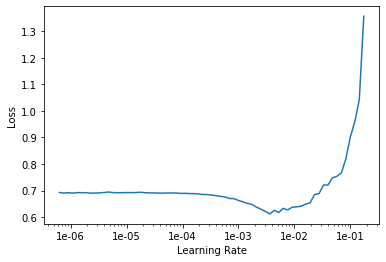

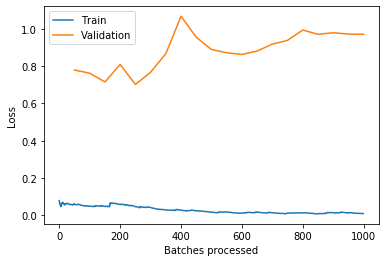

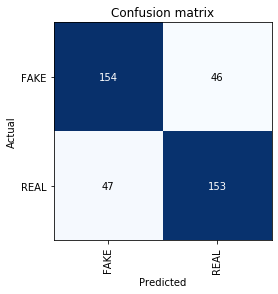

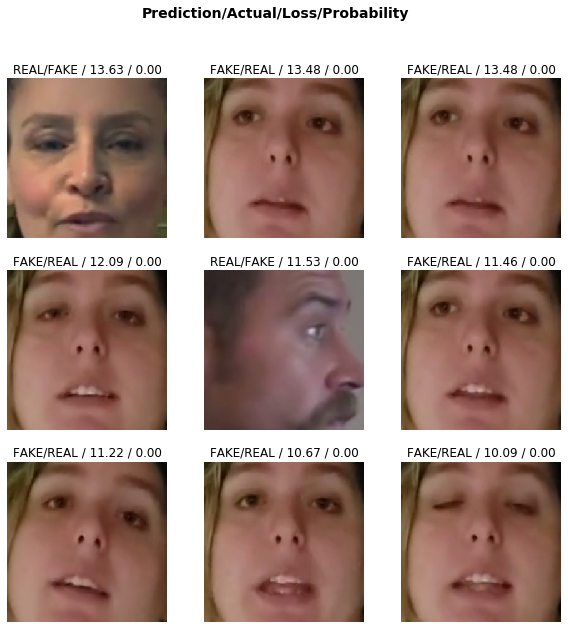

In [16]:
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=data_easy.c)
run_efficientnet(model)

`efficientnetb0` has a final accuracy of **76.75%** and a peak accuracy of **79.75%**

### EfficientNetB1

Loaded pretrained weights for efficientnet-b1


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,0.507466,0.730230,0.622785,00:12
1,0.320676,2.602748,0.650633,00:12
2,0.186961,1.359774,0.794937,00:12
3,0.106058,1.133435,0.812658,00:12
4,0.060784,0.699431,0.850633,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.029720,0.534870,0.878481,00:12
1,0.026303,0.491034,0.881013,00:12
2,0.020795,0.503593,0.881013,00:12
3,0.021717,0.320953,0.903797,00:12
4,0.016835,0.309339,0.916456,00:12
5,0.021830,0.393387,0.903797,00:12
6,0.016394,0.315203,0.911392,00:12
7,0.012329,0.393555,0.888608,00:12
8,0.017018,0.337041,0.906329,00:12
9,0.010352,0.368893,0.908861,00:13


epoch,train_loss,valid_loss,accuracy,time
0,1.140420,0.713370,0.642500,00:13
1,0.521206,0.709969,0.747500,00:12
2,0.299445,0.729213,0.690000,00:13
3,0.175334,0.634158,0.757500,00:13
4,0.113425,0.608513,0.750000,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.058476,0.583030,0.747500,00:13
1,0.050402,0.609839,0.747500,00:13
2,0.048403,0.624472,0.745000,00:12
3,0.042004,0.626745,0.755000,00:12
4,0.037795,0.719516,0.745000,00:13
5,0.028665,0.671603,0.775000,00:13
6,0.025061,0.685195,0.787500,00:13
7,0.026921,0.712521,0.762500,00:13
8,0.026541,0.647742,0.785000,00:13
9,0.020650,0.611636,0.785000,00:12


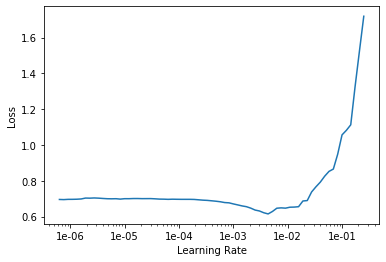

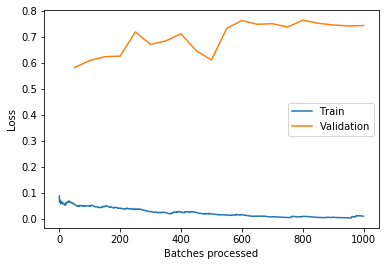

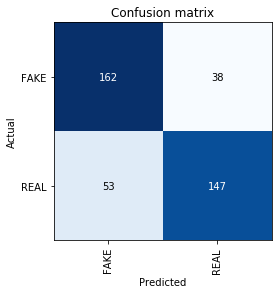

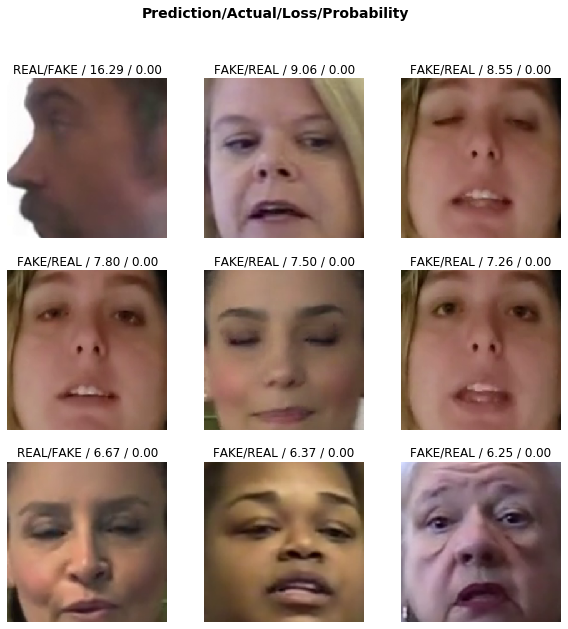

In [10]:
model = EfficientNet.from_pretrained('efficientnet-b1', num_classes=data_easy.c)
run_efficientnet(model)

`efficientnetb1` has a final accuracy of **77.25%** and a peak accuracy of **78.75%**

### EfficientNetB2

Loaded pretrained weights for efficientnet-b2


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,0.471222,1.350980,0.610127,00:12
1,0.308170,1.075278,0.789873,00:13
2,0.200321,0.541079,0.883544,00:13
3,0.106834,0.724425,0.878481,00:12
4,0.059522,0.784028,0.873418,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.023071,0.648045,0.881013,00:12
1,0.023274,0.556338,0.888608,00:13
2,0.024365,0.400494,0.908861,00:12
3,0.021058,0.447564,0.901266,00:13
4,0.014792,0.487100,0.891139,00:12
5,0.025176,0.433980,0.886076,00:13
6,0.018317,0.428796,0.878481,00:13
7,0.011780,0.455281,0.883544,00:13
8,0.009298,0.433141,0.886076,00:13
9,0.009210,0.501313,0.893671,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.981149,0.722509,0.640000,00:13
1,0.465283,0.940859,0.577500,00:13
2,0.267103,1.666276,0.677500,00:13
3,0.158510,1.269011,0.702500,00:14
4,0.091828,1.035779,0.730000,00:14


epoch,train_loss,valid_loss,accuracy,time
0,0.043527,0.911327,0.742500,00:13
1,0.046416,0.843677,0.740000,00:13
2,0.042918,0.810684,0.745000,00:13
3,0.037859,0.768001,0.752500,00:13
4,0.029685,0.768572,0.750000,00:13
5,0.025628,0.787285,0.727500,00:13
6,0.020544,0.823414,0.720000,00:13
7,0.021518,0.946396,0.745000,00:13
8,0.020783,1.073550,0.742500,00:13
9,0.017045,0.876705,0.747500,00:13


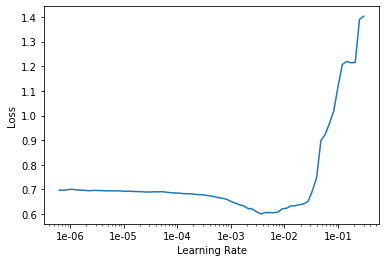

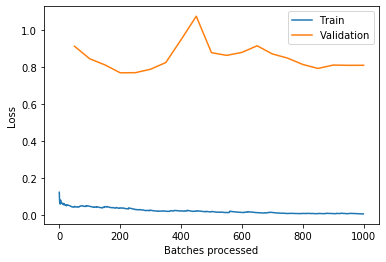

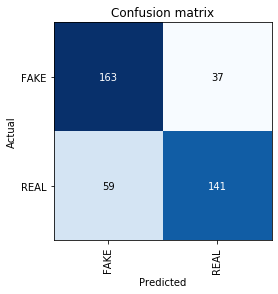

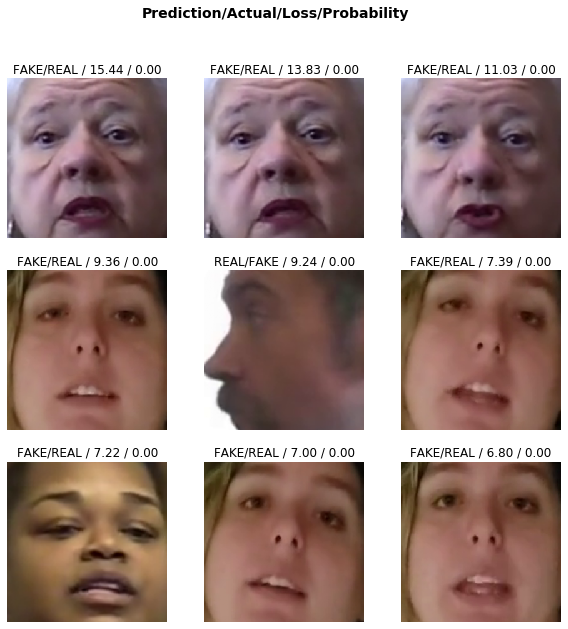

In [12]:
model = EfficientNet.from_pretrained('efficientnet-b2', num_classes=data_easy.c)
run_efficientnet(model)

`efficientnetb2` has a final accuracy of **76.00%** and a peak accuracy of **76.00%**

## Conclusions

ResNets don't seem to improve. Might need more epochs? Overfitting?



|Network         | Pretrained     | Discriminitive | Final Accuracy % | Peak Accuracy %| Time for 1 Epoch (s) |
|----------------|----------------|----------------|------------------|----------------|----------------------|
|`resnet18`      |   True         |   True         | 71.5             | 72.5           | 5                    |
|`resnet34`      |   True         |   True         | 71.0             | 72.0           | 7                    |
|`resnet50`      |   True         |   True         | 68.0             | 73.8           | 12                   |
|`efficientnetb0`|   True         |   False        | 76.3             | 77.8           | 13                   |
|`efficientnetb1`|   True         |   False        | 71.8             | 72.8           | 17.5                 |
|`efficientnetb2`|   True         |   False        | **77.5**         | **78.3**       | 18                   |
|CURRICULUM LEARNING|-------------|----------------|------------------|----------------|----------------------|
|`resnet18`      |   True         |   True         | 73.5             | 78.0           | 5                    |
|`resnet34`      |   True         |   True         | 72.5             | 77.0           | 7                    |
|`resnet50`      |   True         |   True         | 68.0             | 73.8           | 12                   |
|`efficientnetb0`|   True         |   False        | 76.75            | **79.75**      | 13                   |
|`efficientnetb1`|   True         |   False        | **77.25**        | 78.75          | 17.5                 |
|`efficientnetb2`|   True         |   False        | 76.00            | 76.00          | 18                   |